# Credit card default prediction demo

This demo illustrates the problems in evaluating the performance of a classifier, by looking at the problem of predicting credit card default based on information about the credit card applicant.

In [1]:
# Useful imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for plots
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 6.0)
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('data/credit_card_default.csv', na_values=[' ', '  '])
print df.columns

Index([u'CARDHLDR', u'DEFAULT', u'AGE', u'ACADMOS', u'ADEPCNT', u'MAJORDRG',
       u'MINORDRG', u'OWNRENT', u'INCOME', u'SELFEMPL', u'INCPER', u'EXP_INC',
       u'SPENDING', u'LOGSPEND '],
      dtype='object')


Columns are:
```
Cardhldr = Dummy variable, 1 if application for credit card accepted, 0 if not
Default = 1 if defaulted 0 if not (observed when Cardhldr = 1, 10,499 observations),
Age = Age in years plus twelfths of a year,
Adepcnt = 1 + number of dependents,
Acadmos = months living at current address,
Majordrg = Number of major derogatory reports,
Minordrg = Number of minor derogatory reports,
Ownrent = 1 if owns their home, 0 if rent
Income = Monthly income (divided by 10,000),
Selfempl = 1 if self employed, 0 if not,
Inc_per = Income divided by number of dependents,
Exp_Inc = Ratio of monthly credit card expenditure to yearly income,
Spending = Average monthly credit card expenditure (for Cardhldr = 1),
Logspend = Log of spending.
```

We are going to look at the data for people who successfully applied for a credit card, since only in those cases we know if they defaulted or not.

In [3]:
# Extract the rows for card holders alone.
df = df[df.CARDHLDR == 1]

In [4]:
# We want to classify the data in a "default" (0) and a "no-default" (1) class.
target_col = 'DEFAULT'
# We selected a subset of columns as input features.
features_cols = [u'AGE', u'MAJORDRG', u'OWNRENT', u'INCOME', u'SELFEMPL', u'SPENDING']

target = 1 - df[target_col]
features = df[features_cols]

In [5]:
# Divide the data into a training and a test set.
from sklearn.cross_validation import train_test_split

random_state = 0  # Fixed to make the notebook reproducible.
test_set_fraction = 0.3
x_train, x_test, t_train, t_test = train_test_split(
    features, target, test_size=test_set_fraction, random_state=random_state)
print '# train = {}, # test data points = {}'.format(len(x_train), len(x_test))

# train = 7349, # test data points = 3150


In [6]:
# Rescale the features to have zero mean and unit variance.
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(features)
x_test = scaler.transform(x_test)
x_train = scaler.transform(x_train)

We are going to make a first attempt at classification using a Support Vector classifier with radial basis functions.

In [7]:
from sklearn import svm

# Train the classifier.
method = svm.SVC(kernel='rbf', C=100.)
method.fit(x_train, t_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [8]:
# Evaluate on test data.
print 'Accuracy =', method.score(x_test, t_test)

Accuracy = 0.900317460317


This is a quite high accuracy score on test data... should we declare success?

Let's have a look at the confusion matrix, showing class prediction versus ground truth.

In [9]:
from sklearn.metrics import confusion_matrix

y_test = method.predict(x_test)
print confusion_matrix(t_test, y_test)

[[   2  304]
 [  10 2834]]


The high accuracy is due uniquely to the fact that non-default rows are much more common! We are failing completely to capture the default cases, which is what we are mainly interested in.

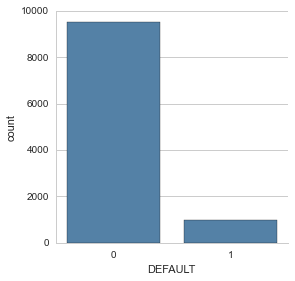

In [10]:
# Distribution of labels in the full data set.
sns.factorplot('DEFAULT', data=df, kind='count', color='steelblue')

The "recall" score measures the percentage of correctly classified cases for each class, and can be used to diagnose this kind of cases.

In [11]:
from sklearn.metrics import recall_score

print 'Recall = ', recall_score(t_test, y_test, average=None)

Recall =  [ 0.00653595  0.99648383]


We can also request a summary table with `classification_report`.

In [12]:
from sklearn.metrics import classification_report

print classification_report(t_test, y_test)

             precision    recall  f1-score   support

          0       0.17      0.01      0.01       306
          1       0.90      1.00      0.95      2844

avg / total       0.83      0.90      0.86      3150



What can we do about it? First of all, we should re-balance the data set by over/undersampling the classes, or weight the data points by their number in the error function, if the classifier allows it.

In [13]:
# `class_weight='auto'` weights points for each class based on their relative number.
# We could also pass a dictionary mapping class label to weight explicitly.
method = svm.SVC(kernel='rbf', C=100., class_weight='auto')
method.fit(x_train, t_train)
print 'Accuracy =', method.score(x_test, t_test)

y_test = method.predict(x_test)

print 'Classification report:'
print classification_report(t_test, y_test)

print 'Confusion matrix:'
y_test = method.predict(x_test)
print confusion_matrix(t_test, y_test)

Accuracy = 0.59619047619
Classification report:
             precision    recall  f1-score   support

          0       0.13      0.56      0.21       306
          1       0.93      0.60      0.73      2844

avg / total       0.85      0.60      0.68      3150

Confusion matrix:
[[ 172  134]
 [1138 1706]]


Another thing to keep in mind is that the classification threshold is somewhat arbitrary, and can be displaced if we are willing to trade false positive errors for false negative errors.

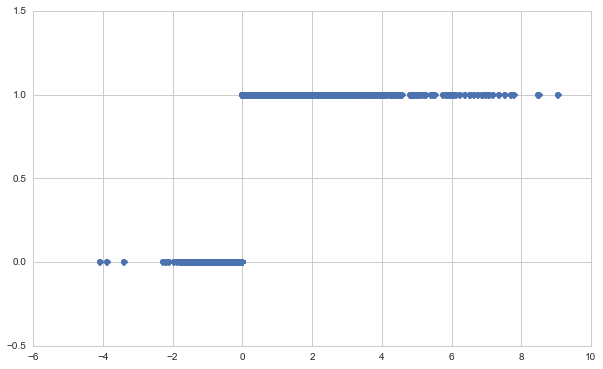

In [14]:
# Show the class labels as a function of the classification function.
score = method.decision_function(x_test)
plt.plot(score, y_test, 'o')
plt.ylim(-0.5, 1.5);

We can get a complete overview of how false positive and false negative errors vary as a function of the threshold using the Receiving Operator Curve (ROC)

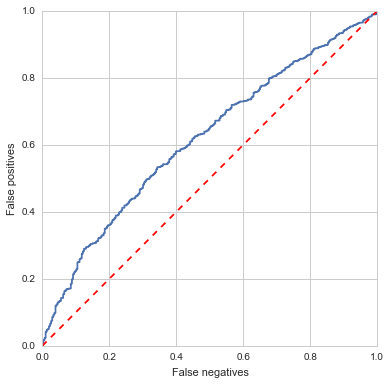

In [15]:
from sklearn.metrics import roc_curve

y_score = method.decision_function(x_test)
fpr, tpr, uh = roc_curve(t_test, y_score)

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False negatives')
plt.ylabel('False positives')

Where you want to be on that curve depends on your costs for either type of error, which would lead us into decision theory.

On the other hand, one can use the Area Under the Curve (AUC) as a measure for the classifier performance.

In [16]:
from sklearn.metrics import auc
print 'AUC = ', auc(fpr, tpr)

AUC =  0.616183135233
